# Step 3: PCA Dimensionality Reduction

This notebook applies Principal Component Analysis (PCA) to reduce the dimensionality of normalized audio features across all datasets.

## Objectives:
1. Load normalized datasets (GTZAN, FMA Small, FMA Medium, Indian, Instrumental)
2. Apply PCA to reduce features while retaining 95% variance
3. Analyze explained variance ratios
4. Visualize PCA results in 2D and 3D
5. Save transformed data for clustering

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import os
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


In [2]:
# Define paths
normalization_dir = '../results/normalization/'
pca_output_dir = '../results/pca/'
os.makedirs(pca_output_dir, exist_ok=True)

# Dataset configurations
datasets = {
    'gtzan': {
        'file': 'gtzan_normalized.csv',
        'label_file': 'gtzan_labels.csv',
        'name': 'GTZAN'
    },
    'fma_small': {
        'file': 'fma_small_normalized.csv',
        'label_file': 'fma_small_labels.csv',
        'name': 'FMA Small'
    },
    'fma_medium': {
        'file': 'fma_medium_normalized.csv',
        'label_file': 'fma_medium_labels.csv',
        'name': 'FMA Medium'
    },
    'ludwig': {
        'file': 'ludwig_normalized.csv',
        'label_file': 'ludwig_labels.csv',
        'name': 'Ludwig'
    },
    'indian': {
        'file': 'indian_normalized.csv',
        'label_file': 'indian_labels.csv',
        'name': 'Indian Music'
    }
}

print(f"Output directory: {pca_output_dir}")
print(f"Datasets to process: {list(datasets.keys())}")

Output directory: ../results/pca/
Datasets to process: ['gtzan', 'fma_small', 'fma_medium', 'ludwig', 'indian']


## Function Definitions

In [3]:
def apply_pca(data, n_components=0.95):
    """
    Apply PCA to the data
    
    Parameters:
    - data: DataFrame with features
    - n_components: Number of components or variance ratio to retain
    
    Returns:
    - pca_data: Transformed data
    - pca_model: Fitted PCA model
    """
    pca = PCA(n_components=n_components)
    pca_data = pca.fit_transform(data)
    
    return pca_data, pca

def plot_explained_variance(pca, dataset_name, output_dir):
    """
    Plot cumulative explained variance
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Individual explained variance
    ax1.bar(range(1, len(pca.explained_variance_ratio_) + 1), 
            pca.explained_variance_ratio_, 
            alpha=0.7, color='steelblue')
    ax1.set_xlabel('Principal Component', fontsize=12)
    ax1.set_ylabel('Explained Variance Ratio', fontsize=12)
    ax1.set_title(f'{dataset_name}: Explained Variance by Component', fontsize=14, fontweight='bold')
    ax1.grid(alpha=0.3)
    
    # Cumulative explained variance
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    ax2.plot(range(1, len(cumsum) + 1), cumsum, 
             marker='o', linestyle='-', color='darkred', linewidth=2)
    ax2.axhline(y=0.95, color='green', linestyle='--', label='95% Variance')
    ax2.set_xlabel('Number of Components', fontsize=12)
    ax2.set_ylabel('Cumulative Explained Variance', fontsize=12)
    ax2.set_title(f'{dataset_name}: Cumulative Explained Variance', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}{dataset_name.lower().replace(" ", "_")}_explained_variance.png', 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    return cumsum

def plot_pca_2d(pca_data, labels, dataset_name, output_dir):
    """
    Plot 2D PCA visualization
    """
    plt.figure(figsize=(12, 8))
    
    unique_labels = labels.unique()
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))
    
    for idx, label in enumerate(unique_labels):
        mask = labels == label
        plt.scatter(pca_data[mask, 0], pca_data[mask, 1], 
                   c=[colors[idx]], label=label, alpha=0.6, s=50)
    
    plt.xlabel(f'First Principal Component', fontsize=12)
    plt.ylabel(f'Second Principal Component', fontsize=12)
    plt.title(f'{dataset_name}: PCA Visualization (2D)', fontsize=14, fontweight='bold')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{output_dir}{dataset_name.lower().replace(" ", "_")}_pca_2d.png', 
                dpi=300, bbox_inches='tight')
    plt.show()

def plot_pca_3d(pca_data, labels, dataset_name, output_dir):
    """
    Plot 3D PCA visualization
    """
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')
    
    unique_labels = labels.unique()
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))
    
    for idx, label in enumerate(unique_labels):
        mask = labels == label
        ax.scatter(pca_data[mask, 0], pca_data[mask, 1], pca_data[mask, 2],
                  c=[colors[idx]], label=label, alpha=0.6, s=30)
    
    ax.set_xlabel('PC1', fontsize=11)
    ax.set_ylabel('PC2', fontsize=11)
    ax.set_zlabel('PC3', fontsize=11)
    ax.set_title(f'{dataset_name}: PCA Visualization (3D)', fontsize=14, fontweight='bold')
    ax.legend(bbox_to_anchor=(1.15, 1), loc='upper left', fontsize=8)
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}{dataset_name.lower().replace(" ", "_")}_pca_3d.png', 
                dpi=300, bbox_inches='tight')
    plt.show()

print("✓ Functions defined successfully!")

✓ Functions defined successfully!


## Process All Datasets

In [4]:
# Store results
pca_results = {}

for key, config in datasets.items():
    print(f"\n{'='*60}")
    print(f"Processing: {config['name']}")
    print(f"{'='*60}")
    
    # Load normalized data
    data_path = os.path.join(normalization_dir, config['file'])
    label_path = os.path.join(normalization_dir, config['label_file'])
    
    try:
        df = pd.read_csv(data_path)
        labels_df = pd.read_csv(label_path)
        
        print(f"✓ Loaded {config['name']}: {df.shape}")
        print(f"  Features: {df.shape[1]}")
        print(f"  Samples: {df.shape[0]}")
        
        # Apply PCA (95% variance)
        pca_data, pca_model = apply_pca(df, n_components=0.95)
        
        print(f"\n✓ PCA Applied:")
        print(f"  Original dimensions: {df.shape[1]}")
        print(f"  Reduced dimensions: {pca_data.shape[1]}")
        print(f"  Total variance explained: {pca_model.explained_variance_ratio_.sum():.4f}")
        print(f"  Variance retained: {pca_model.explained_variance_ratio_.sum() * 100:.2f}%")
        
        # Store results
        pca_results[key] = {
            'data': pca_data,
            'model': pca_model,
            'labels': labels_df.iloc[:, 0],
            'original_shape': df.shape,
            'reduced_shape': pca_data.shape
        }
        
        # Save PCA-transformed data
        pca_df = pd.DataFrame(
            pca_data,
            columns=[f'PC{i+1}' for i in range(pca_data.shape[1])]
        )
        output_file = f'{pca_output_dir}{key}_pca.csv'
        pca_df.to_csv(output_file, index=False)
        print(f"✓ Saved to: {output_file}")
        
    except Exception as e:
        print(f"✗ Error processing {config['name']}: {str(e)}")
        continue

print(f"\n{'='*60}")
print("PCA Processing Complete!")
print(f"{'='*60}")


Processing: GTZAN
✓ Loaded GTZAN: (999, 69)
  Features: 69
  Samples: 999

✓ PCA Applied:
  Original dimensions: 69
  Reduced dimensions: 39
  Total variance explained: 0.9505
  Variance retained: 95.05%
✓ Saved to: ../results/pca/gtzan_pca.csv

Processing: FMA Small
✓ Loaded FMA Small: (7996, 70)
  Features: 70
  Samples: 7996

✓ PCA Applied:
  Original dimensions: 70
  Reduced dimensions: 45
  Total variance explained: 0.9508
  Variance retained: 95.08%
✓ Saved to: ../results/pca/fma_small_pca.csv

Processing: FMA Medium
✓ Loaded FMA Medium: (16986, 70)
  Features: 70
  Samples: 16986

✓ PCA Applied:
  Original dimensions: 70
  Reduced dimensions: 45
  Total variance explained: 0.9529
  Variance retained: 95.29%
✓ Saved to: ../results/pca/fma_small_pca.csv

Processing: FMA Medium
✓ Loaded FMA Medium: (16986, 70)
  Features: 70
  Samples: 16986

✓ PCA Applied:
  Original dimensions: 70
  Reduced dimensions: 45
  Total variance explained: 0.9529
  Variance retained: 95.29%
✓ Saved to:

## Visualizations: Explained Variance


Generating explained variance plot for GTZAN...


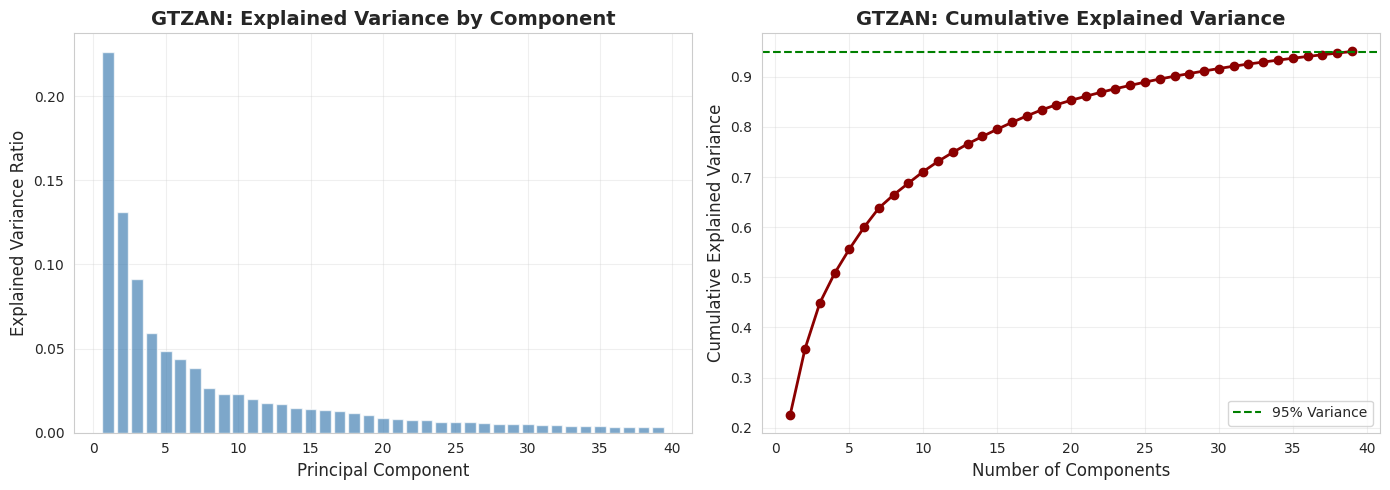

  Components for 95% variance: 39

Generating explained variance plot for FMA Small...


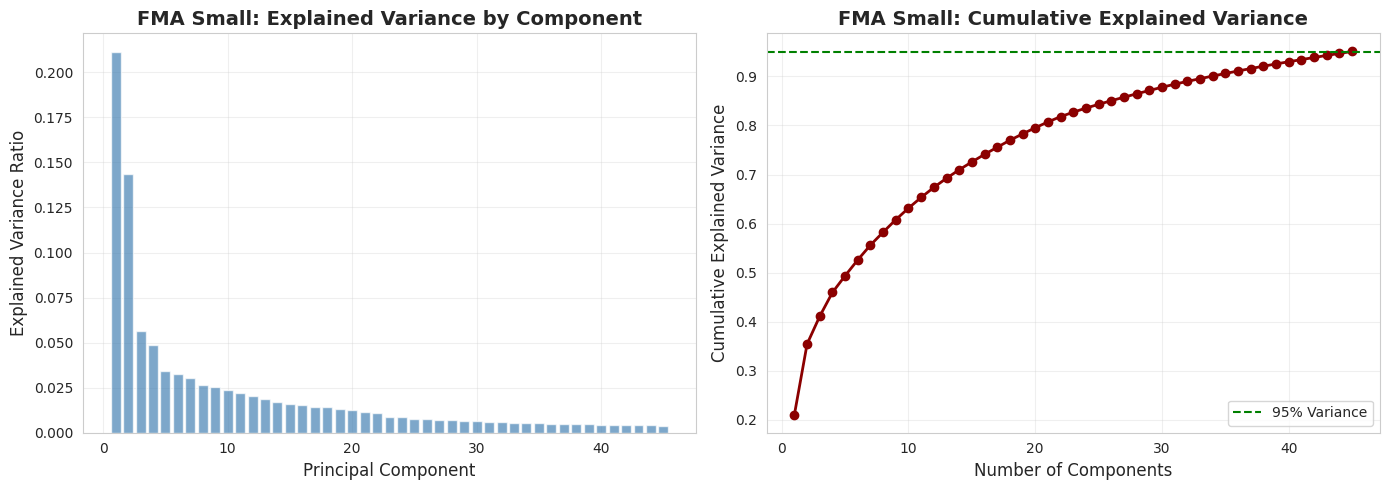

  Components for 95% variance: 45

Generating explained variance plot for FMA Medium...


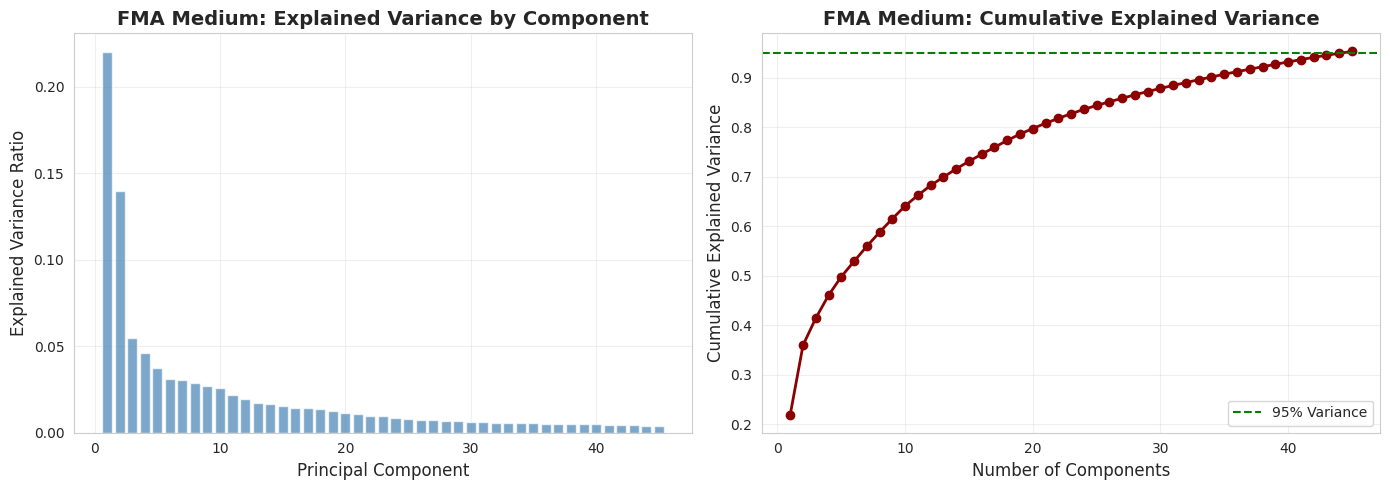

  Components for 95% variance: 45

Generating explained variance plot for Ludwig...


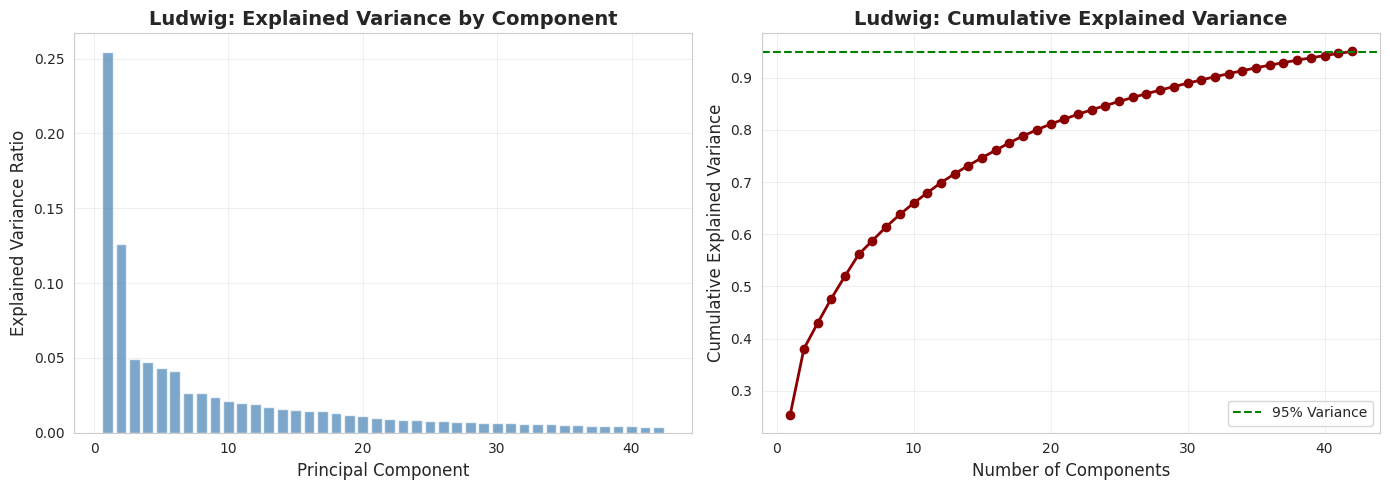

  Components for 95% variance: 42

Generating explained variance plot for Indian Music...


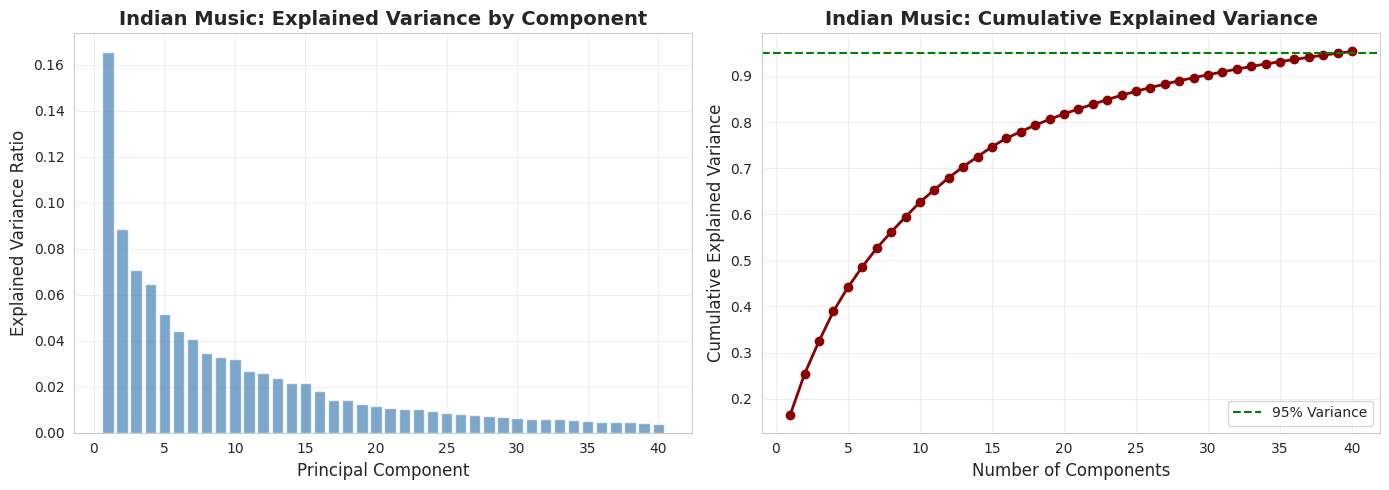

  Components for 95% variance: 40


In [5]:
# Generate explained variance plots for all datasets
for key, result in pca_results.items():
    config = datasets[key]
    print(f"\nGenerating explained variance plot for {config['name']}...")
    cumsum = plot_explained_variance(result['model'], config['name'], pca_output_dir)
    
    # Find number of components for 95% variance
    n_components_95 = np.argmax(cumsum >= 0.95) + 1
    print(f"  Components for 95% variance: {n_components_95}")

## Visualizations: 2D PCA Plots


Generating 2D PCA plot for GTZAN...


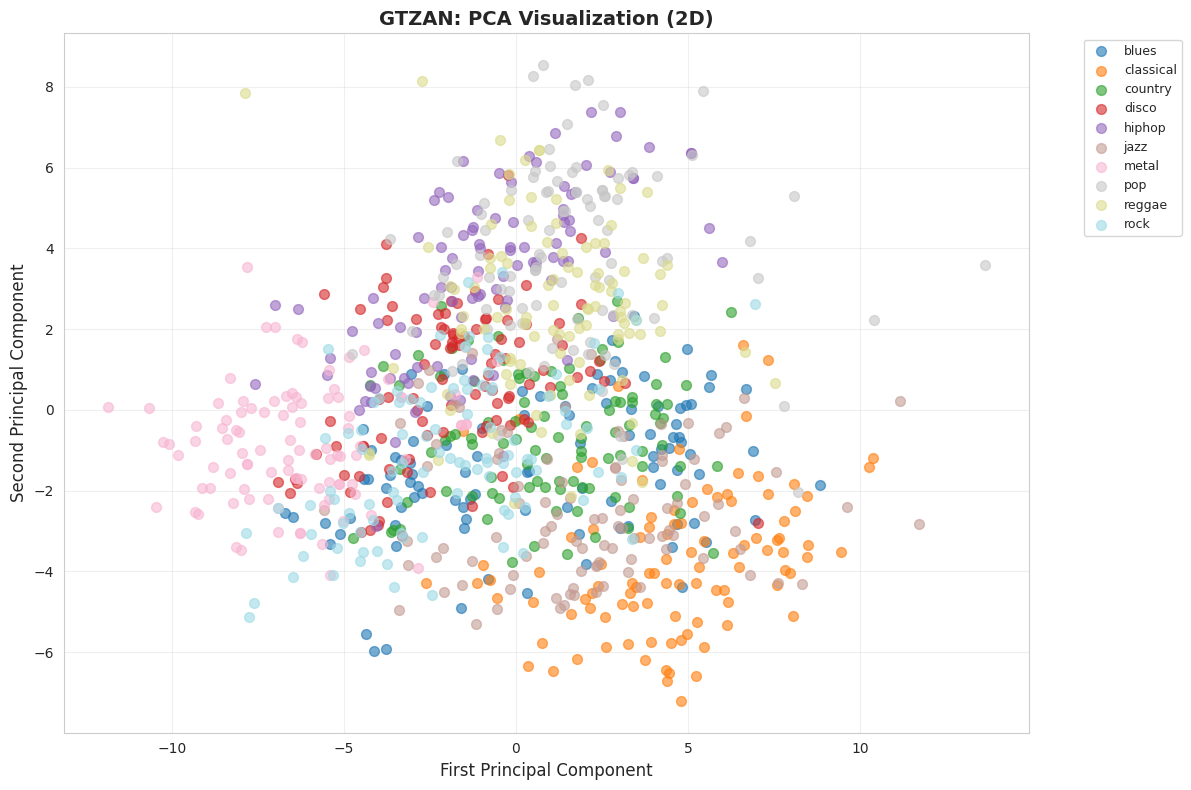


Generating 2D PCA plot for FMA Small...


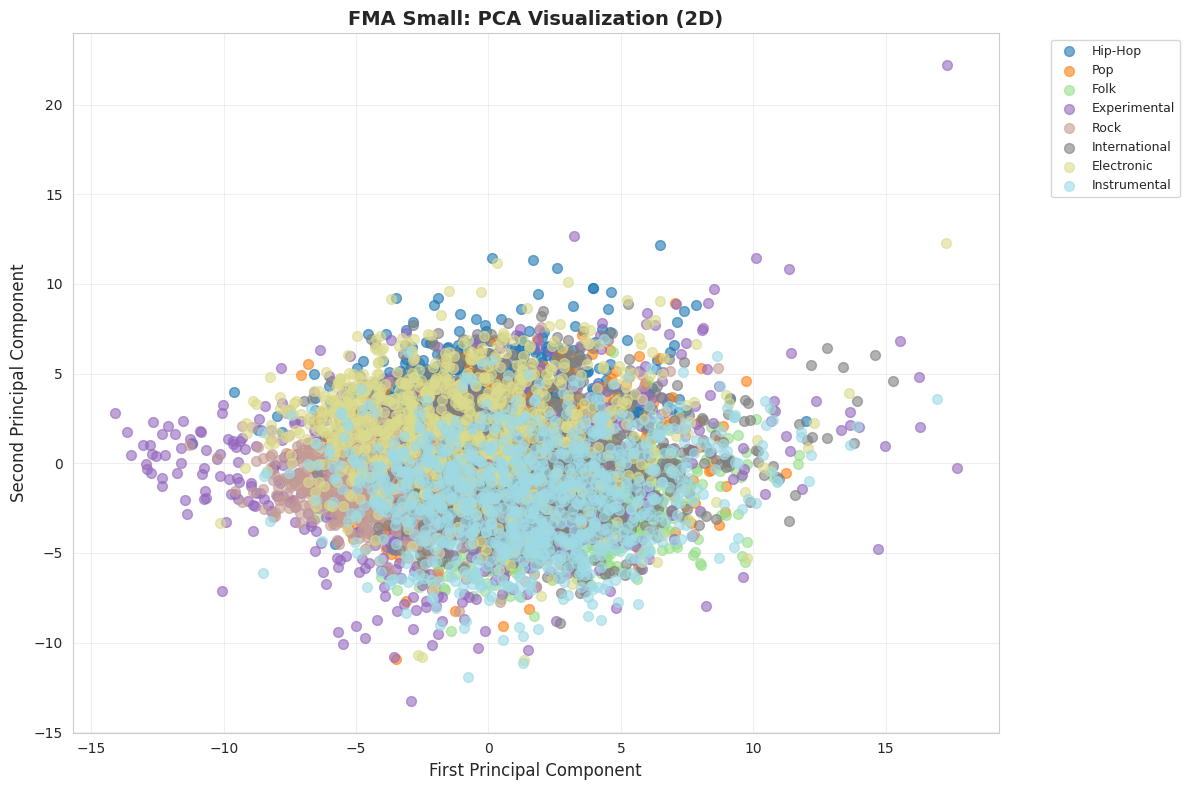


Generating 2D PCA plot for FMA Medium...


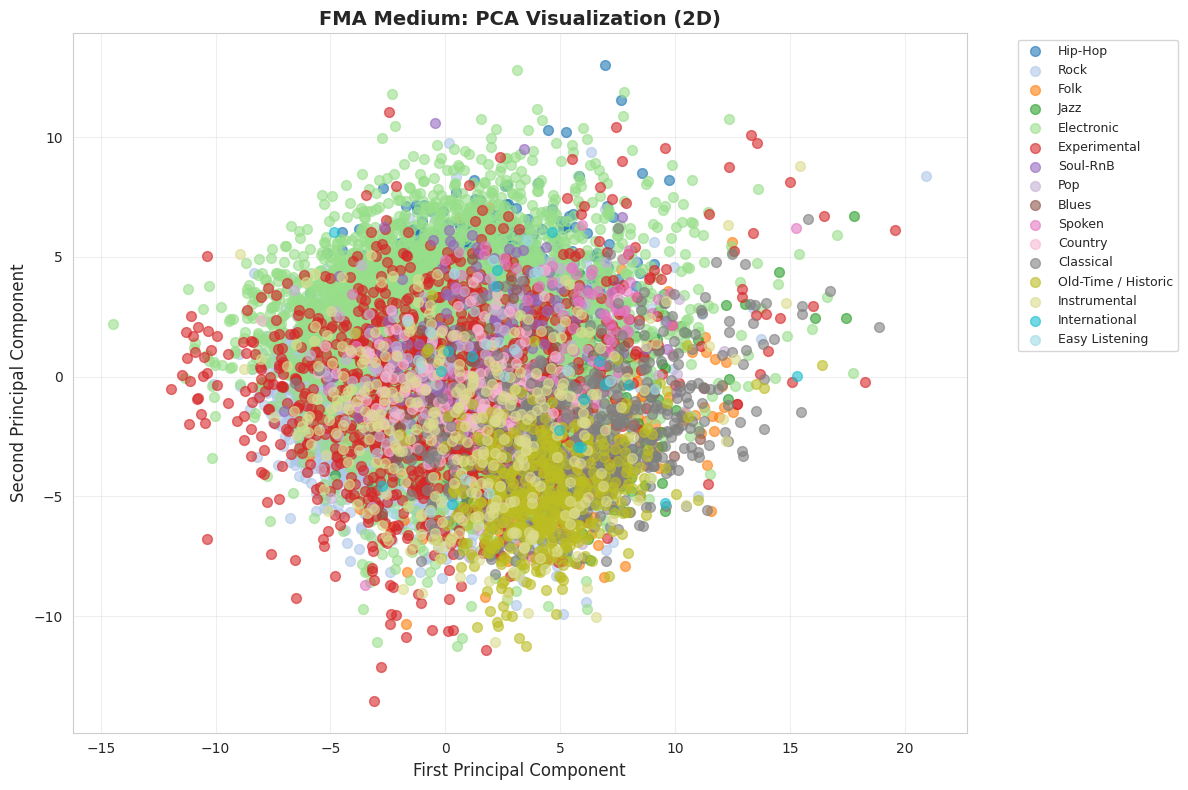


Generating 2D PCA plot for Ludwig...


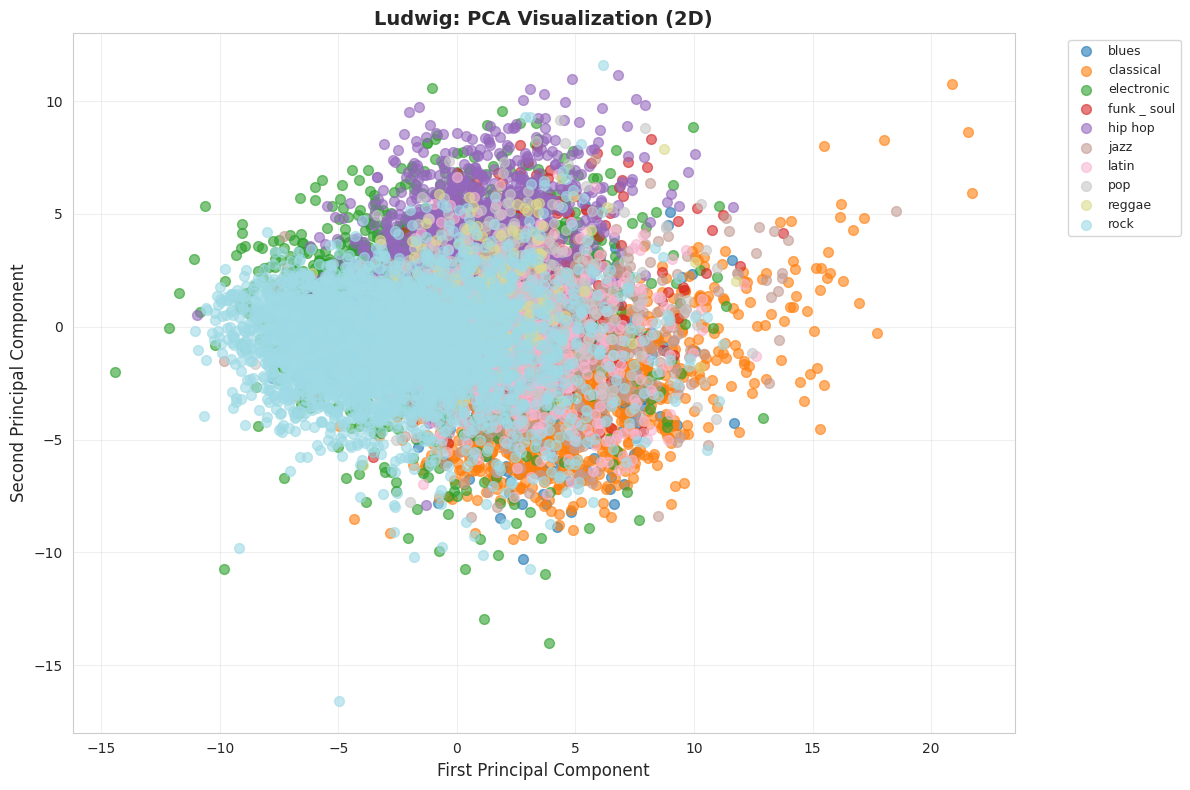


Generating 2D PCA plot for Indian Music...


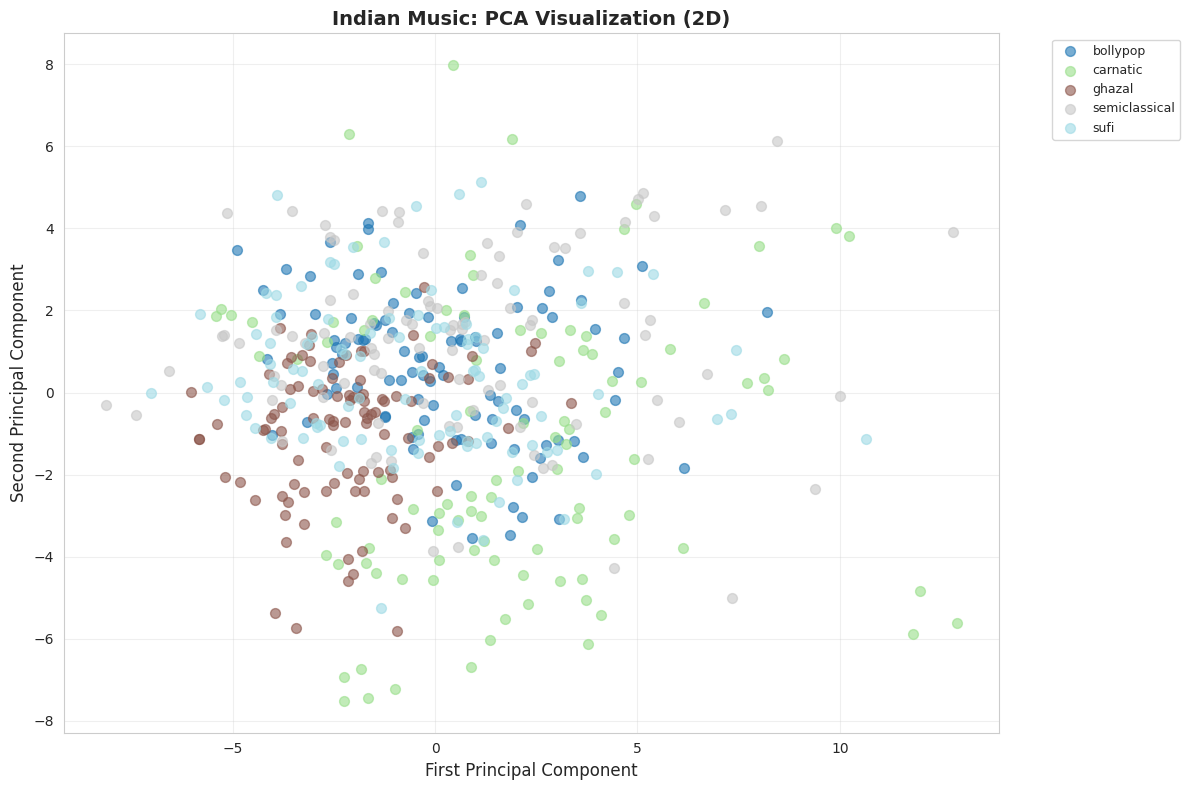

In [6]:
# Generate 2D PCA visualizations
for key, result in pca_results.items():
    config = datasets[key]
    print(f"\nGenerating 2D PCA plot for {config['name']}...")
    plot_pca_2d(result['data'], result['labels'], config['name'], pca_output_dir)

## Visualizations: 3D PCA Plots


Generating 3D PCA plot for GTZAN...


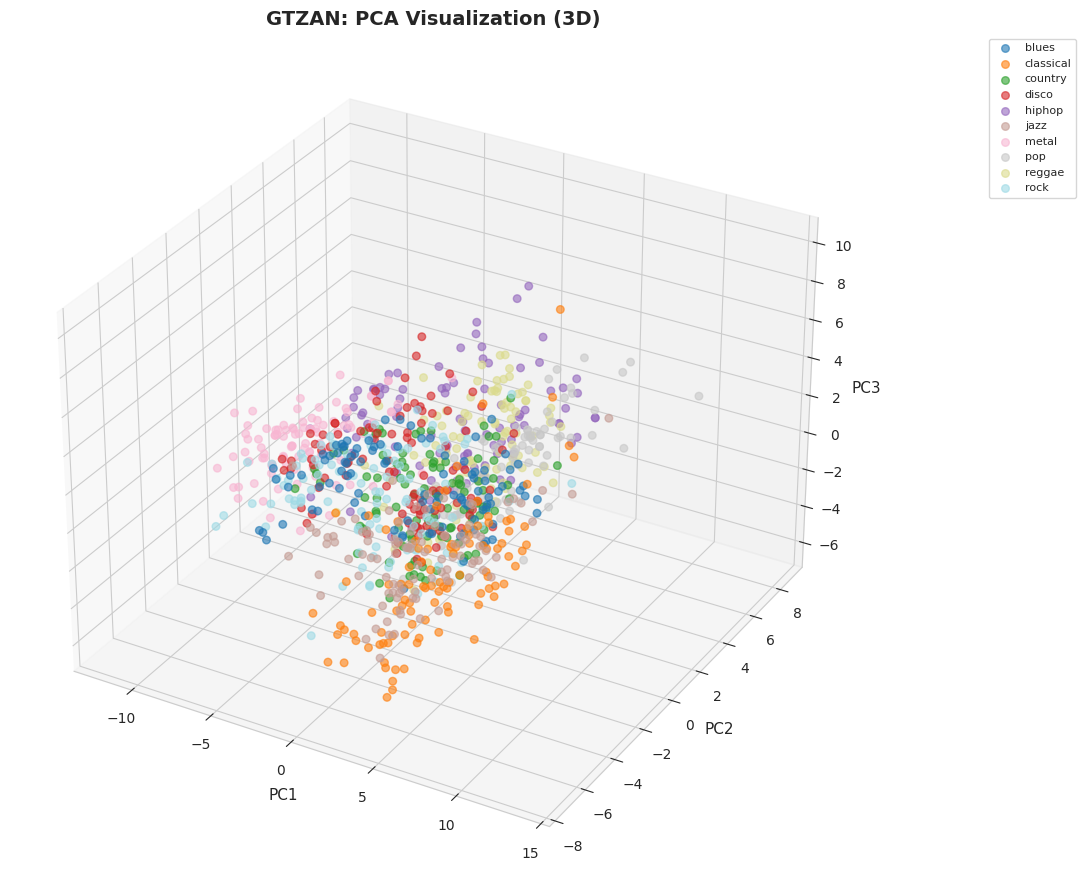


Generating 3D PCA plot for FMA Small...


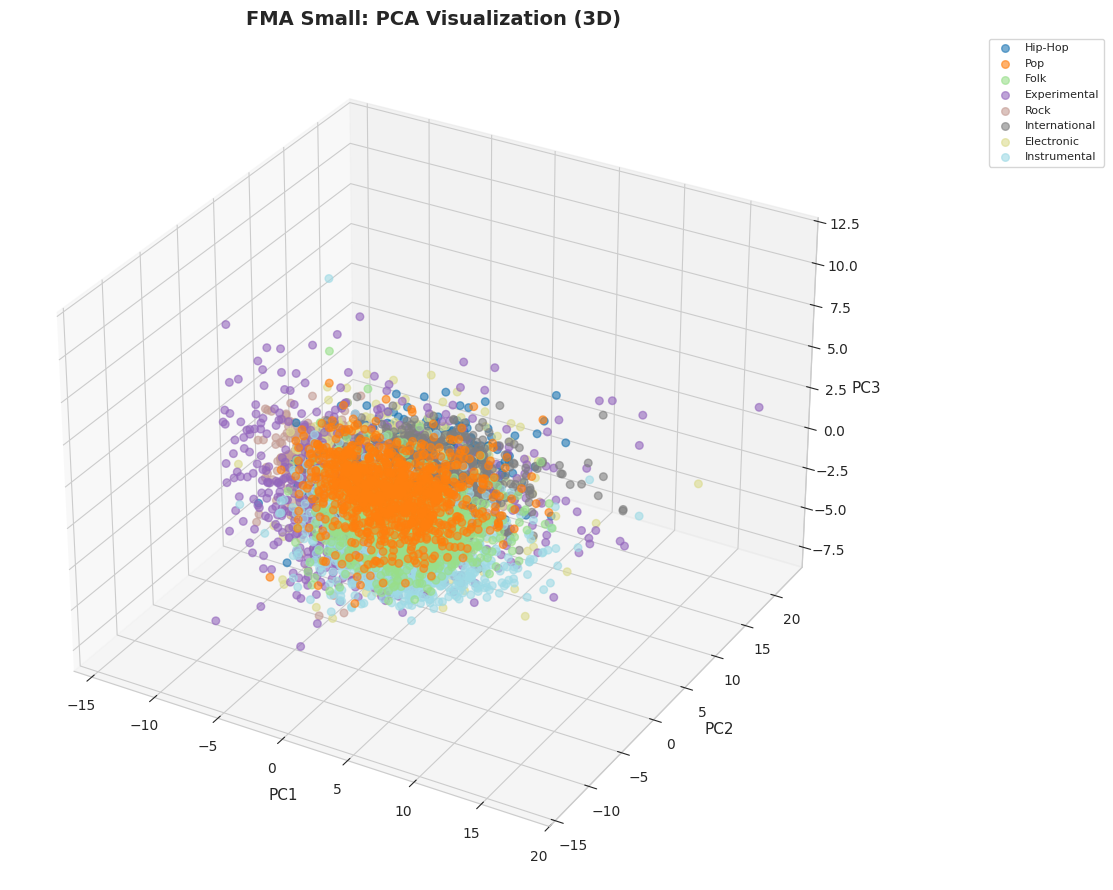


Generating 3D PCA plot for FMA Medium...


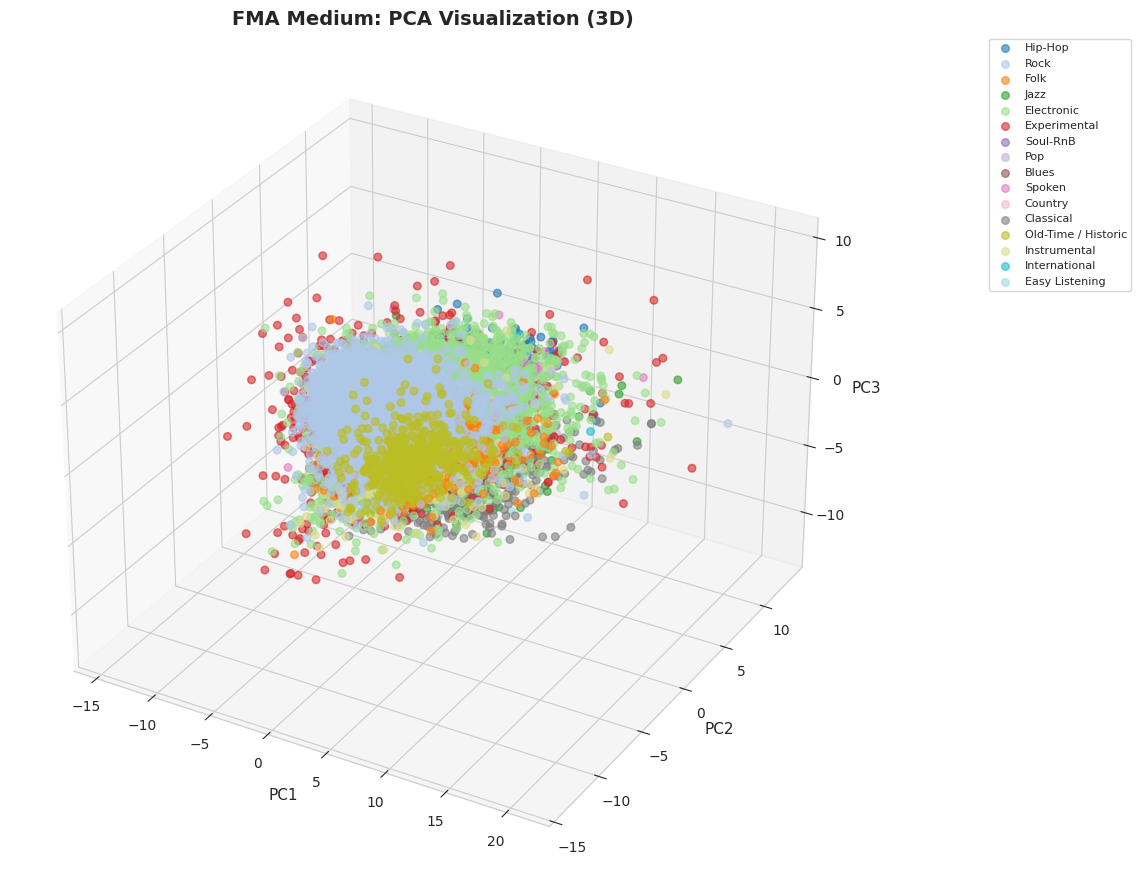


Generating 3D PCA plot for Ludwig...


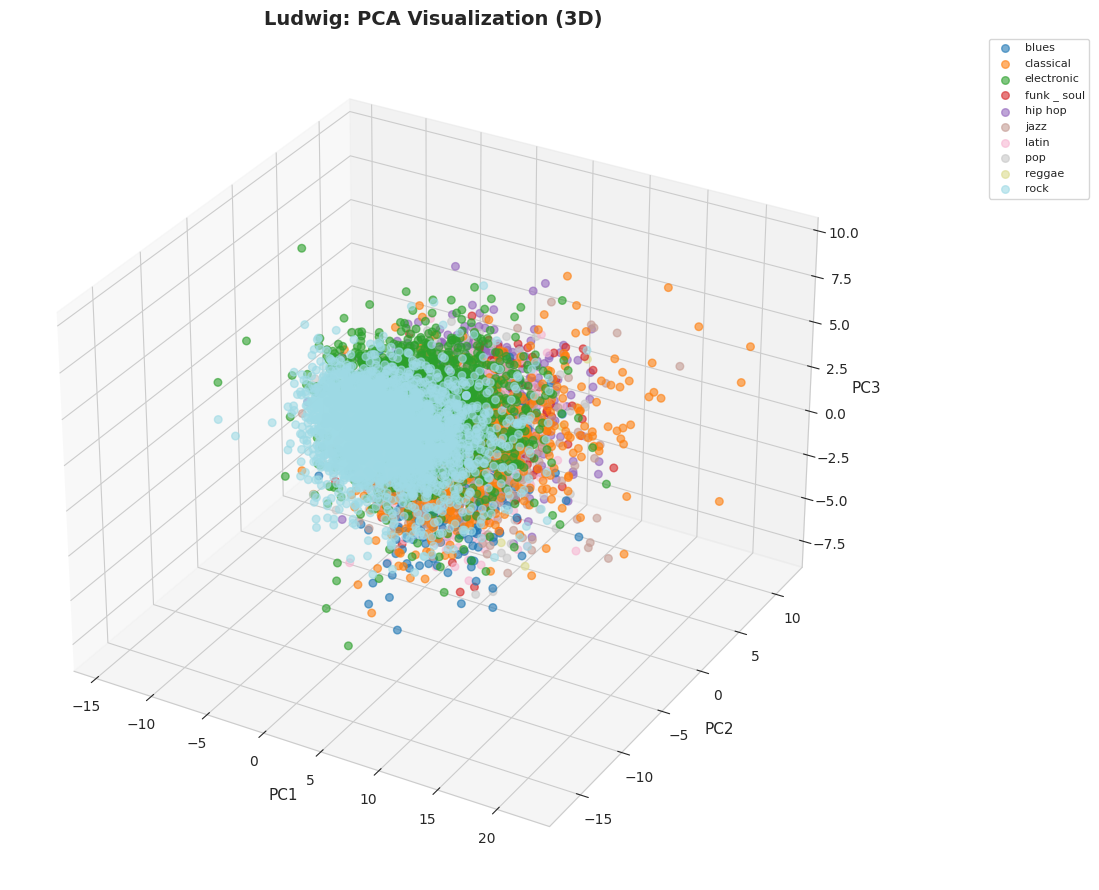


Generating 3D PCA plot for Indian Music...


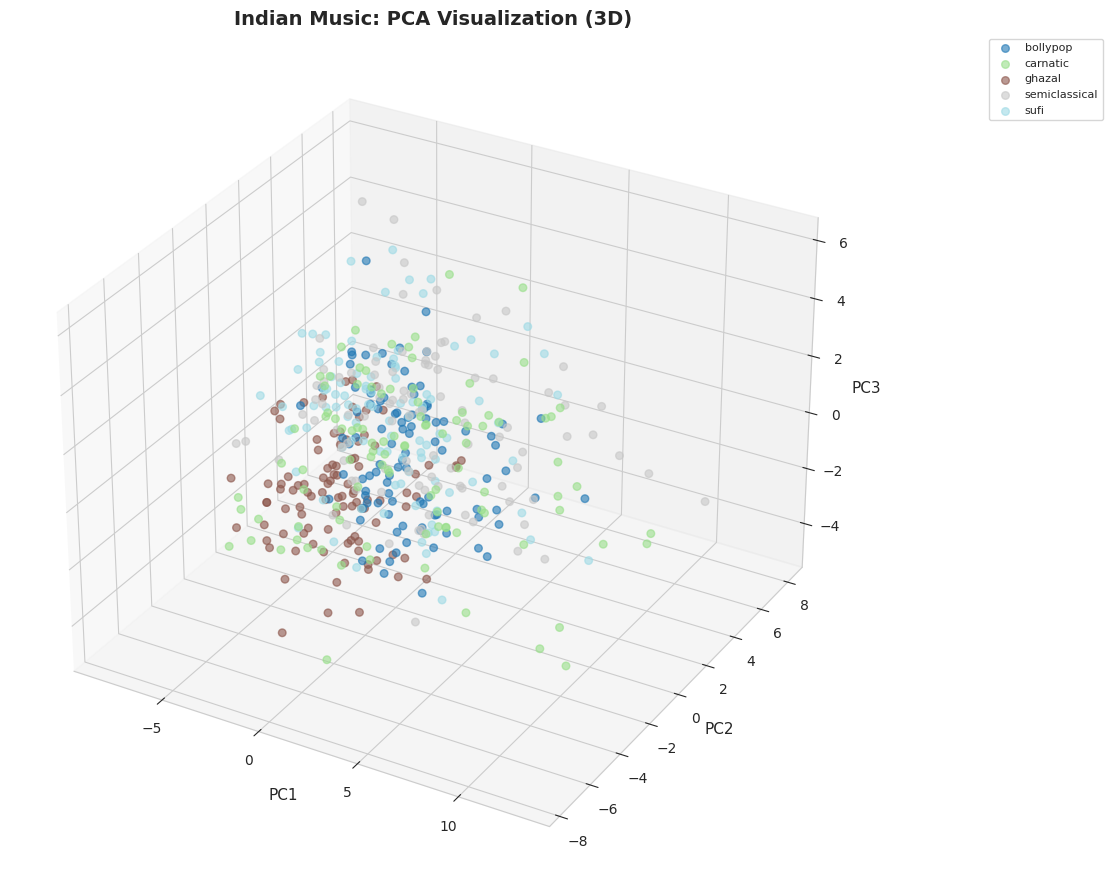

In [7]:
# Generate 3D PCA visualizations
for key, result in pca_results.items():
    config = datasets[key]
    print(f"\nGenerating 3D PCA plot for {config['name']}...")
    plot_pca_3d(result['data'], result['labels'], config['name'], pca_output_dir)

## Summary Report

In [8]:
# Create summary report
summary_data = []

for key, result in pca_results.items():
    config = datasets[key]
    summary_data.append({
        'Dataset': config['name'],
        'Original Features': result['original_shape'][1],
        'Samples': result['original_shape'][0],
        'PCA Components': result['reduced_shape'][1],
        'Variance Retained': f"{result['model'].explained_variance_ratio_.sum() * 100:.2f}%",
        'Reduction Ratio': f"{(1 - result['reduced_shape'][1] / result['original_shape'][1]) * 100:.1f}%"
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*80)
print("PCA DIMENSIONALITY REDUCTION SUMMARY")
print("="*80)
print(summary_df.to_string(index=False))
print("="*80)

# Save summary
summary_file = f'{pca_output_dir}pca_summary_report.csv'
summary_df.to_csv(summary_file, index=False)
print(f"\n✓ Summary saved to: {summary_file}")

# Create detailed text report
report_file = f'{pca_output_dir}pca_analysis_report.txt'
with open(report_file, 'w') as f:
    f.write("="*80 + "\n")
    f.write("PCA DIMENSIONALITY REDUCTION - DETAILED REPORT\n")
    f.write("="*80 + "\n\n")
    
    for key, result in pca_results.items():
        config = datasets[key]
        f.write(f"\n{config['name']}:\n")
        f.write("-" * 60 + "\n")
        f.write(f"Original dimensions: {result['original_shape'][1]} features\n")
        f.write(f"Reduced dimensions: {result['reduced_shape'][1]} components\n")
        f.write(f"Number of samples: {result['original_shape'][0]}\n")
        f.write(f"Total variance explained: {result['model'].explained_variance_ratio_.sum():.6f}\n")
        f.write(f"Variance retained: {result['model'].explained_variance_ratio_.sum() * 100:.2f}%\n")
        f.write(f"\nTop 5 Principal Components:\n")
        for i in range(min(5, len(result['model'].explained_variance_ratio_))):
            f.write(f"  PC{i+1}: {result['model'].explained_variance_ratio_[i]:.6f} ")
            f.write(f"({result['model'].explained_variance_ratio_[i] * 100:.2f}%)\n")
        f.write("\n")

print(f"✓ Detailed report saved to: {report_file}")

print("\n" + "="*80)
print("✓ PCA ANALYSIS COMPLETE!")
print("="*80)


PCA DIMENSIONALITY REDUCTION SUMMARY
     Dataset  Original Features  Samples  PCA Components Variance Retained Reduction Ratio
       GTZAN                 69      999              39            95.05%           43.5%
   FMA Small                 70     7996              45            95.08%           35.7%
  FMA Medium                 70    16986              45            95.29%           35.7%
      Ludwig                 69    11293              42            95.03%           39.1%
Indian Music                 69      500              40            95.30%           42.0%

✓ Summary saved to: ../results/pca/pca_summary_report.csv
✓ Detailed report saved to: ../results/pca/pca_analysis_report.txt

✓ PCA ANALYSIS COMPLETE!
